# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

## Problem 3
Now let's move to the next stage:
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right)&=\left(f, \chi_{h}\right) \\
\left(\operatorname{curl}_{h} z_{h}, \operatorname{curl}_{h} v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) \\
\left(\phi_{h}, \psi_{h}\right)+\varepsilon^{2}\left(\nabla_{h} \phi_{h}, \nabla_{h} \psi_{h}\right)+\left(\operatorname{div}_{h} \psi_{h}, p_{h}\right) &=\left(\operatorname{curl}_{h} z_{h}, \psi_{h}\right) \\
\left(\operatorname{div}_{h} \phi_{h}, q_{h}\right) &=0 \\
\left(\operatorname{curl}_{h} u_{h 0}, \operatorname{curl}_{h} \chi_{h}\right) &=\left(\phi_{h}, \operatorname{curl}_{h} \chi_{h}\right)
\end{aligned}
$$

In [3]:
from skfem import *
import numpy as np
from utils import solver_iter_krylov, solver_iter_pyamg, solver_iter_mgcg
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod, div, curl
from scipy.sparse.linalg import LinearOperator, minres
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
from skfem.visuals.matplotlib import draw, plot
import scipy.sparse.linalg as spl
from scipy.sparse import bmat
from skfem.visuals.matplotlib import draw, plot
import datetime
import pandas as pd
import sys
import time

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

# parameters

tol = 1e-5
intorder = 3
solver_type = 'mgcg'
refine_time = 2
epsilon_range = 4
zero_ep = False
element_type = 'P1'
sigma = 5
penalty = True
example = 'ex1'

## Forms and errors

In [4]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D


@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))


@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

## Example 1

In [5]:
@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    lu = 2 * (pi)**2 * (cos(2 * pix) * ((sin(piy))**2) + cos(2 * piy) *
                        ((sin(pix))**2))
    llu = -8 * (pi)**4 * (cos(2 * pix) * sin(piy)**2 + cos(2 * piy) *
                        sin(pix)**2 - cos(2 * pix) * cos(2 * piy))
    return (epsilon**2 * llu - lu) * v


def exact_u(x, y):
    return (sin(pi * x) * sin(pi * y))**2


def dexact_u(x, y):
    dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
    duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
    return dux, duy


def ddexact(x, y):
    duxx = 2 * pi**2 * cos(pi * x)**2 * sin(pi * y)**2 - 2 * pi**2 * sin(
        pi * x)**2 * sin(pi * y)**2
    duxy = 2 * pi * cos(pi * x) * sin(pi * x) * 2 * pi * cos(pi * y) * sin(
        pi * y)
    duyx = duxy
    duyy = 2 * pi**2 * cos(pi * y)**2 * sin(pi * x)**2 - 2 * pi**2 * sin(
        pi * y)**2 * sin(pi * x)**2
    return duxx, duxy, duyx, duyy

## Solver

In [6]:
def solve_problem1(m, element_type='P1', solver_type='pcg'):
    '''
    switching to mgcg solver for problem 1
    '''
    if element_type == 'P1':
        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    elif element_type == 'P2':
        element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    else:
        raise Exception("Element not supported")

    basis = {
        variable: InteriorBasis(m, e, intorder=intorder)
        for variable, e in element.items()
    }  # intorder: integration order for quadrature

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    if solver_type == 'amg':
        wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_pyamg(tol=tol))
    elif solver_type == 'pcg':
        wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
    elif solver_type == 'mgcg':
        wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
    else:
        raise Exception("Solver not supported")

    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh

    if solver_type == 'amg':
        uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])), solver=solver_iter_pyamg(tol=tol))
    elif solver_type == 'pcg':
        uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])), solver=solver_iter_krylov(Precondition=True, tol=tol))
    elif solver_type == 'mgcg':
        uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])), solver=solver_iter_mgcg(tol=tol))
    else:
        raise Exception("Solver not supported")

    return uh0, basis

## Solving

In [51]:
epsilon = 0
ep = epsilon

### Equation 1
$$
\left(\nabla w_{h}, \nabla \chi_{h}\right)=\left(f, \chi_{h}\right)
$$

In [52]:
m = MeshTri()
m.refine(5)
element1 = ElementTriP1()

basis1 = InteriorBasis(m, element1, intorder=intorder)

K1 = asm(laplace, basis1)
f1 = asm(f_load, basis1)

wh = solve(*condense(K1, f1, D=basis1.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))

In [53]:
wh

array([ 0.        ,  0.        ,  0.        , ..., 30.8481859 ,
       27.09370376, 27.09370376])

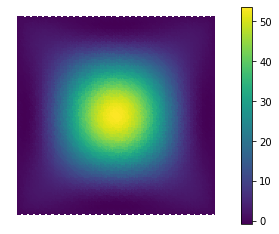

In [54]:
plot(basis1, wh, colorbar=True)

In [55]:
basis1.doflocs[0]

array([0.     , 1.     , 0.     , ..., 0.65625, 0.6875 , 0.65625])

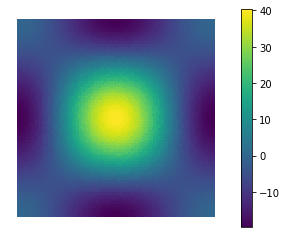

In [58]:
def exact_w(x, y):
    pix = pi * x
    piy = pi * y
    lu = 2 * (pi)**2 * (cos(2 * pix) * sin(piy)**2 +
                        cos(2 * piy) * sin(pix)**2)
    u = (sin(pix) * sin(piy))**2
    return -(epsilon**2 * lu - u)


plot(basis1, exact_w(basis1.doflocs[0], basis1.doflocs[1]), colorbar=True)

### Equation 2
$$
\left(\operatorname{curl}_{h} z_{h}, \operatorname{curl}_{h} v_{h}\right)=\left(\nabla w_{h}, \nabla_{h} v_{h}\right)
$$

In [59]:
@BilinearForm
def zv_load(u, v, w):
    '''
    for 5.7a
    '''
    global uuu, vvv
    uuu = u
    vvv = v
    return dot(curl(u), curl(v))

In [60]:
element2 = ElementTriMorley()
basis2 = InteriorBasis(m, element2, intorder=intorder)

K2 = asm(zv_load, basis2)
f2 = asm(laplace, basis1, basis2) * wh

# zh = solve(*condense(K2, f2, D=basis2.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
zh = solve(*condense(K2, f2, D=easy_boundary(basis2)), solver=solver_iter_krylov(Precondition=True, tol=tol))

In [61]:
zh

array([   0.        ,    0.        ,    0.        , ..., -105.41249576,
        105.41249576,  157.84916069])

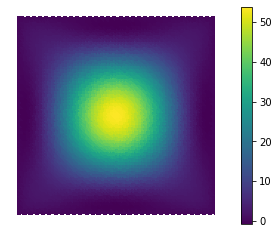

In [62]:
plot(basis2, zh, colorbar=True)

### Equation 3
$$
\begin{aligned}
\left(\phi_{h}, \psi_{h}\right)+\varepsilon^{2}\left(\nabla_{h} \phi_{h}, \nabla_{h} \psi_{h}\right)+\left(\operatorname{div}_{h} \psi_{h}, p_{h}\right) &=\left(\operatorname{curl}_{h} z_{h}, \psi_{h}\right) \\
\left(\operatorname{div}_{h} \phi_{h}, q_{h}\right)&=0
\end{aligned}
$$

In [63]:
class ElementTriP1CR(ElementH1):
    
    facet_dofs = 1
    dim = 2
    maxdeg = 1
    dofnames = ['u']
    doflocs = np.array([[.5, 0.], [.5, .5], [0., .5]])
    mesh_type = MeshTri

    def lbasis(self, X, i):
        x, y = X

        if i == 0:
            phi = 1. - 2. * y
            dphi = np.array([0. * x, -2. + 0. * y])
        elif i == 1:
            phi = 2. * x + 2. * y - 1.
            dphi = np.array([2. + 0. * x, 2. + 0. * y])
        elif i == 2:
            phi = 1. - 2. * x
            dphi = np.array([-2. + 0. * x, 0. * x])
        else:
            self._index_error()
        return phi, dphi

In [64]:
@BilinearForm
def phipsi_load1(u, v, w):
    '''
    for 5.7b $(phi, psi)$
    '''
    return ddot(u, v)

@BilinearForm
def phipsi_load2(u, v, w):
    '''
    for 5.7b $(Laplace_phi, Laplace_psi)$
    '''
    return ddot(grad(u), grad(v))


@BilinearForm
def phipsi_load3(u, v, w):
    '''
    for 5.7b $(div_phi, p)$
    '''
    return div(u) * v


@BilinearForm
def zpsi_load(u, v, w):
    '''
    for 5.7b $(curl_z, psi)$
    '''
    return ddot(curl(u), v)


@BilinearForm
def phiq_load(u, v, w):
    '''
    for 5.7c $(div_phi, q)$
    '''
    return div(u) * v


@BilinearForm
def mass(u, v, w):
    '''
    for 5.7c C
    '''
    return u * v * 1e-6

In [65]:
element3 = {'phi': ElementVectorH1(ElementTriP1CR()), 'p': ElementTriP0()}
basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  

A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * asm(phipsi_load2, basis3['phi'])
B = asm(phiq_load, basis3['phi'], basis3['p'])
C = asm(mass, basis3['p'])
F1 = asm(zpsi_load, basis2, basis3['phi']) * zh

f3 = np.concatenate([F1, np.zeros(B.shape[0])])
K3 = bmat([[A, -B.T], [-B, C*0]], 'csr')

phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))

phih, ph = np.split(phip, [A.shape[0]])

In [66]:
element3 = {'phi': ElementVectorH1(ElementTriP1CR()), 'p': ElementTriP0()}
basis3 = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element3.items()}  

A = asm(phipsi_load1, basis3['phi']) + epsilon**2 * asm(phipsi_load2, basis3['phi'])
B = asm(phiq_load, basis3['phi'], basis3['p'])
C = asm(mass, basis3['p'])
F1 = asm(zpsi_load, basis2, basis3['phi']) * zh

f3 = np.concatenate([F1, np.zeros(B.shape[0])])
K3 = bmat([[A, -B.T], [-B, C * 0]], 'csr')

# phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=1e-5))
phip = solve(*condense(K3, f3, D=basis3['phi'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-13))
phih, ph = np.split(phip, [A.shape[0]])

In [67]:
phih

array([0.        , 0.        , 0.        , ..., 0.56619818, 0.04010102,
       0.4710666 ])

In [68]:
phih.shape

(6272,)

In [69]:
phih[::2]

array([ 0.        ,  0.        ,  0.        , ..., -0.26412366,
        0.06410064,  0.04010102])

In [70]:
testbasis = InteriorBasis(m, ElementTriP1CR(), intorder=intorder)

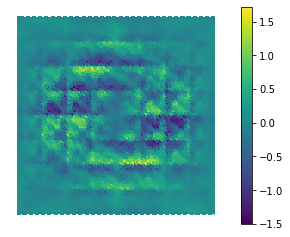

In [71]:
plot(testbasis, phih[::2], colorbar=True)

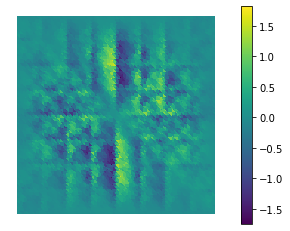

In [72]:
plot(testbasis, phih[1::2], colorbar=True)

### Exact $\phi$

In [73]:
exact_phi = dexact_u(testbasis.doflocs[0], testbasis.doflocs[1])

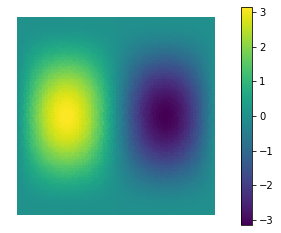

In [74]:
plot(testbasis, exact_phi[0], colorbar=True)

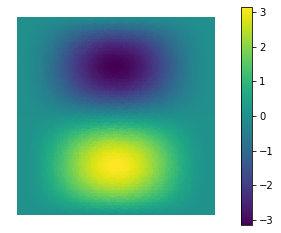

In [75]:
plot(testbasis, exact_phi[1], colorbar=True)

In [76]:
ph.shape

(2048,)

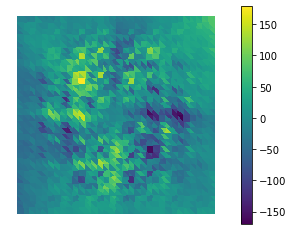

In [77]:
plot(basis3['p'], ph, colorbar=True)

### Equation 4
$$
\left(\operatorname{curl}_{h} u_{h 0}, \operatorname{curl}_{h} \chi_{h}\right)=\left(\phi_{h}, \operatorname{curl}_{h} \chi_{h}\right)
$$

In [78]:
@BilinearForm
def phichi_load(u, v, w):
    '''
    for 5.7d $(phi, curl_chi)$
    '''
    return ddot(u, curl(v))

In [79]:
element4 = ElementTriMorley()
basis4 = InteriorBasis(m, element4, intorder=intorder)

K4 = asm(zv_load, basis4)
f4 = asm(phichi_load, basis3['phi'], basis4) * phih

# uh = solve(*condense(K4, f4, D=basis4.find_dofs()), solver=solver_iter_krylov(Precondition=True, tol=tol))
uh = solve(*condense(K4, f4, D=easy_boundary(basis4)), solver=solver_iter_krylov(Precondition=True, tol=tol))

In [80]:
u = exact_u(basis4.doflocs[0], basis4.doflocs[1])

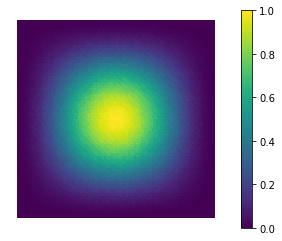

In [81]:
plot(basis4, u, colorbar=True)

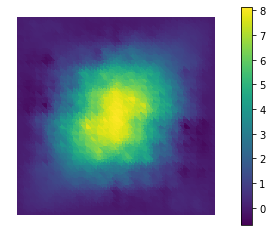

In [82]:
plot(basis4, uh, colorbar=True)

### Error Estimation

In [38]:
U = basis2.interpolate(uh).value

L2u = np.sqrt(L2uError.assemble(basis2, w=U))

In [39]:
L2u

0.09279806470172904

# Other codes

In [ ]:
df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2) * (1 - zero_ep)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, refine_time+1):
        
        m.refine()
        
        if penalty:
            uh0, basis = solve_problem2(m, element_type, solver_type)
        else:
            uh0, basis = solve_problem1(m, element_type, solver_type)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
#         print(
#             '2^-' + str(i + 2), ' {:.5f}  {:.5f}  {:.5f}  {:.5f}'.format(
#                 L2s[i + 1], H1s[i + 1],
#                 H2s[i + 1],
#                 epus[i + 1]))